### The Reuters dataset

- _Reuters dataset_, is a set of short newswires and their topics, published by Reuters in 1986.  
- There are 46 different topics some topics are more represented than others, but each topic has at least 10 examples in the training set.
- The dataset can be loaded using the following script. Specifically, it retrieves 8,982 training examples and 2,246 test examples. The argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the data.

Note, here we only use Keras to download the dataset. The deep learning model should be done in PyTorch.

In [ ]:
!pip install torchinfo

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow.keras
from tensorflow.keras.datasets import reuters
import pandas as pd

from torchinfo import summary

import matplotlib.pyplot as plt


# add your import statement
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [ ]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# show the sizes training/testing samples 
len(train_data)
len(test_data)

2121728/2110848 [==============================] - 0s 0us/step


8982

2246

Each example is a list of integers, each corresponds to one word (word indices).  The following shows one example. Also, you can decode it back to words, in case you are curious:

In [ ]:
# show an example from the training dataset
print(train_data[10])

# retrieve the mapping from words to indices
word_index = reuters.get_word_index()

# reverse mapping
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index[i - 3] for i in train_data[0] if (i-3) in reverse_word_index])

decoded_newswire

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]
565248/550378 [==============================] - 0s 0us/step


'said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index. In total, there are `46` topics.


The code below shows the label for one sample and also the distribution of labels. This dataset is very imbalanced. Some labels only have a few training samples.

In [ ]:
train_labels[10]

# distribution of labels

pd.Series(train_labels).value_counts().sort_values(ascending = False)

3

3     3159
4     1949
19     549
16     444
1      432
11     390
20     269
13     172
8      139
10     124
9      101
21     100
25      92
2       74
18      66
24      62
0       55
34      50
36      49
12      49
6       48
28      48
30      45
23      41
31      39
17      39
40      36
32      32
41      30
14      26
39      24
26      24
43      21
15      20
29      19
37      19
38      19
45      18
5       17
7       16
27      15
22      15
42      13
44      12
33      11
35      10
dtype: int64

### Prepare data
First, we'll follow the "bad-of-words" approach to generating sample representations. You can vectorize the data with the following code. Specifically,
- The training/test datasets is represented as a matrix
- Each sample is treated as a row, and each word is a column. 
- If a word (say $j$) appears in a sample (say $i$), 1 is recorded in the cell ($i, j$), and 0 otherwise.

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

# Get Y ready
y_train = np.array(train_labels)
y_test = np.array(test_labels)

x_train.shape
x_test.shape

y_train.shape
y_test.shape

(8982, 10000)

(2246, 10000)

(8982,)

(2246,)

### Create seqential models in different architectures



In [ ]:
# fix random number

random_seed = 124
#seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [ ]:
# Create dataset class

class news_dataset(Dataset):
    
    # add your code

    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = y #torch.from_numpy(y).float()
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__ (self):
        return len(self.x)


train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

In [ ]:
# Define your models: A, B, C
        

class linear_model(nn.Module):
    def __init__(self, h1, h2=None):  # add more parameters if needsed
        
       # add your code
        super(linear_model, self).__init__()
        if h2:
           self.classifier = nn.Sequential(
                nn.Linear(in_features=10000, out_features=h1),
                nn.ReLU(),
                nn.Linear(in_features=h1, out_features=h2),
                nn.ReLU(),
                nn.Linear(in_features=h2, out_features=46)
           )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(in_features=10000, out_features=h1),
                nn.ReLU(),
                nn.Linear(in_features=h1, out_features=46)
            )
    
    def forward(self, x):
        output = self.classifier(x)
        return output
        

In [ ]:
# Define a train function



def train_model(model, train_dataset, test_dataset, device, lr=0.0002, epochs=30, batch_size=256, l2= 0):  # add more parameters if needed
    
    history = {'train_loss': [], #train_
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    
    # add your code

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

  
    model = model.to(device)   


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay= l2) 

  
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x, y in train_loader:
            
            x = x.to(device)
            y = y.to(device)
          
            outputs = model(x) 
            score, pred = torch.max(outputs, 1)    
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).sum().item() / batch_size
            
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += cur_train_loss
            train_acc += cur_train_acc

      
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
              
                outputs = model(x) 
                score, pred = torch.max(outputs,1)                  
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().item() / batch_size 
                
                test_loss += cur_test_loss
                test_acc += cur_test_acc    

        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f} train_acc:{train_acc:.5f}, Test loss:{val_loss:.5f} Test acc:{val_acc:.5f}")
  
    return history

    

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Train Model A

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

# load model
modela = linear_model(h1 = 128)
summary(modela, (24, 10000))
hista = train_model(modela, train_dataset, test_dataset, device, epochs=50, l2 = 0)      

Layer (type:depth-idx)                   Output Shape              Param #
linear_model                             --                        --
├─Sequential: 1-1                        [24, 46]                  --
│    └─Linear: 2-1                       [24, 128]                 1,280,128
│    └─ReLU: 2-2                         [24, 128]                 --
│    └─Linear: 2-3                       [24, 46]                  5,934
Total params: 1,286,062
Trainable params: 1,286,062
Non-trainable params: 0
Total mult-adds (M): 30.87
Input size (MB): 0.96
Forward/backward pass size (MB): 0.03
Params size (MB): 5.14
Estimated Total Size (MB): 6.14

Training Start
Epoch:1 / 50, train loss:2.53346 train_acc:0.56141, Test loss:1.93352 Test acc:0.62934
Epoch:2 / 50, train loss:1.61726 train_acc:0.66862, Test loss:1.57476 Test acc:0.65972
Epoch:3 / 50, train loss:1.31948 train_acc:0.71039, Test loss:1.40157 Test acc:0.68533
Epoch:4 / 50, train loss:1.14321 train_acc:0.74208, Test loss:1.29412 Test acc:0.70095
Epoch:5 / 50, train loss:1.01899 train_acc:0.76595, Test loss:1.21689 Test acc:0.71571
Epoch:6 / 50, train loss:0.92072 train_acc:0.78635, Test loss:1.15709 Test acc:0.72873
Epoch:7 / 50, train loss:0.83885 train_acc:0.80414, Test loss:1.10843 Test acc:0.73915
Epoch:8 / 50, train loss:0.76808 train_acc:0.82107, Test loss:1.06748 Test acc:0.74957
Epoch:9 / 50, train loss:0.70543 train_acc:0.83398, Test loss:1.03235 Test acc:0.75738
Epoch:10 / 50, train loss:0.64915 train_acc:0.84581, Test loss:1.00195 Test acc:0.76345
Epoch:11 / 50, train loss:0.59814 train_acc:0.85699, Test loss:0.97542 Test acc:0.76736
Epoch:12 / 50, train loss:

In [ ]:
# Train Model B

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

modelb = linear_model(h1=128, h2=64)
summary(modelb, (24, 10000))
histb = train_model(modelb, train_dataset, test_dataset, device, epochs = 50, l2 = 0)

Layer (type:depth-idx)                   Output Shape              Param #
linear_model                             --                        --
├─Sequential: 1-1                        [24, 46]                  --
│    └─Linear: 2-1                       [24, 128]                 1,280,128
│    └─ReLU: 2-2                         [24, 128]                 --
│    └─Linear: 2-3                       [24, 64]                  8,256
│    └─ReLU: 2-4                         [24, 64]                  --
│    └─Linear: 2-5                       [24, 46]                  2,990
Total params: 1,291,374
Trainable params: 1,291,374
Non-trainable params: 0
Total mult-adds (M): 30.99
Input size (MB): 0.96
Forward/backward pass size (MB): 0.05
Params size (MB): 5.17
Estimated Total Size (MB): 6.17

Training Start
Epoch:1 / 50, train loss:2.73816 train_acc:0.41612, Test loss:1.98960 Test acc:0.57465
Epoch:2 / 50, train loss:1.68401 train_acc:0.62500, Test loss:1.60525 Test acc:0.63368
Epoch:3 / 50, train loss:1.40015 train_acc:0.67350, Test loss:1.45258 Test acc:0.66363
Epoch:4 / 50, train loss:1.24272 train_acc:0.70193, Test loss:1.36027 Test acc:0.67578
Epoch:5 / 50, train loss:1.12872 train_acc:0.72721, Test loss:1.29260 Test acc:0.68750
Epoch:6 / 50, train loss:1.03472 train_acc:0.74859, Test loss:1.23821 Test acc:0.69531
Epoch:7 / 50, train loss:0.95395 train_acc:0.76671, Test loss:1.19353 Test acc:0.70356
Epoch:8 / 50, train loss:0.88247 train_acc:0.78179, Test loss:1.15498 Test acc:0.71137
Epoch:9 / 50, train loss:0.81660 train_acc:0.79720, Test loss:1.12144 Test acc:0.72569
Epoch:10 / 50, train loss:0.75561 train_acc:0.80935, Test loss:1.09263 Test acc:0.73741
Epoch:11 / 50, train loss:0.69965 train_acc:0.82096, Test loss:1.06830 Test acc:0.74002
Epoch:12 / 50, train loss:

In [ ]:
# Train Model C

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

modelc = linear_model(h1=128, h2=16)
summary(modelc, (24, 10000))
histc = train_model(modelc, train_dataset, test_dataset, device, epochs = 50, l2 = 0)

Layer (type:depth-idx)                   Output Shape              Param #
linear_model                             --                        --
├─Sequential: 1-1                        [24, 46]                  --
│    └─Linear: 2-1                       [24, 128]                 1,280,128
│    └─ReLU: 2-2                         [24, 128]                 --
│    └─Linear: 2-3                       [24, 16]                  2,064
│    └─ReLU: 2-4                         [24, 16]                  --
│    └─Linear: 2-5                       [24, 46]                  782
Total params: 1,282,974
Trainable params: 1,282,974
Non-trainable params: 0
Total mult-adds (M): 30.79
Input size (MB): 0.96
Forward/backward pass size (MB): 0.04
Params size (MB): 5.13
Estimated Total Size (MB): 6.13

Training Start
Epoch:1 / 50, train loss:3.21656 train_acc:0.30490, Test loss:2.64498 Test acc:0.52300
Epoch:2 / 50, train loss:2.24610 train_acc:0.57487, Test loss:2.03986 Test acc:0.58854
Epoch:3 / 50, train loss:1.80433 train_acc:0.61241, Test loss:1.78762 Test acc:0.60981
Epoch:4 / 50, train loss:1.58792 train_acc:0.64214, Test loss:1.65083 Test acc:0.62934
Epoch:5 / 50, train loss:1.45015 train_acc:0.66493, Test loss:1.56283 Test acc:0.64062
Epoch:6 / 50, train loss:1.34920 train_acc:0.68088, Test loss:1.49835 Test acc:0.65234
Epoch:7 / 50, train loss:1.26847 train_acc:0.69390, Test loss:1.44934 Test acc:0.66102
Epoch:8 / 50, train loss:1.20002 train_acc:0.70421, Test loss:1.40866 Test acc:0.66623
Epoch:9 / 50, train loss:1.13934 train_acc:0.71582, Test loss:1.37392 Test acc:0.67318
Epoch:10 / 50, train loss:1.08390 train_acc:0.72754, Test loss:1.34355 Test acc:0.67491
Epoch:11 / 50, train loss:1.03258 train_acc:0.74132, Test loss:1.31658 Test acc:0.68012
Epoch:12 / 50, train loss:

Text(0.5, 1.0, 'Test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

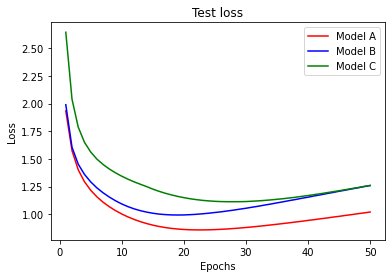

In [ ]:
# Plot test loss curves
epochs = range(1, len(hista['train_loss']) + 1)

plt.plot(epochs, hista['test_loss'], 'r-', label='Model A')
plt.plot(epochs, histb['test_loss'], 'b-', label='Model B')
plt.plot(epochs, histc['test_loss'], 'g-', label='Model C')

plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Test Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

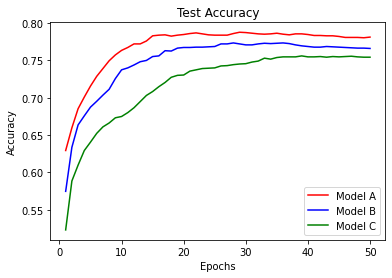

In [ ]:
# Plot test accuracy curves

epochs = range(1, len(hista['test_acc']) + 1)

plt.plot(epochs, hista['test_acc'], 'r-', label='Model A');
plt.plot(epochs, histb['test_acc'], 'b-', label='Model B');
plt.plot(epochs, histc['test_acc'], 'g-', label='Model C');

plt.title('Test Accuracy');
plt.xlabel('Epochs');
plt.ylabel('Accuracy');
plt.legend();

plt.show()

### Fight overfitting 
- Take the `best model` you achieved from Q1 and add regularizers in order to reduce or at least delay overfitting without hurting its classification accuracy. You can consider the following strategies:
    1. `dropout`: Add Dropout layers to input or hidden layers
    2. `Batch Normalization`: Add Batch Normalization layers after hidden layers.
    3. `L1/L2 Regularizer`: Add L2/L1 normal penality with appropriate coefficient.


- Pick one or a combination of strategies and modify the model


- Train the  model as in Q1 


- Plot test loss and test accuracy vs. epoches from the training histories of all the models.


- Write your analysis (as markdowns) on the following: 
   - Are you able to find a good strategy to address overfitting in this case? If so, why do you think the strategy you used can be effective?
   - What other strategies have you tried? Are they effective?
   - Overall, through Q1 and Q2, can you summarize what you have learned regarding modeling and training?
   - Note, this is an open question. Feel free to share you learning experience. We'll summarize all students' analyses and share them in class.
  

A reference plot is provided. However, depending on the strategy you choose, you may get a different plot.

In [ ]:
# Define model with regularizer (dropout technique)
class linear_model_with_regularizer(nn.Module):
    
   # add your code here

    def __init__(self, h1 = 128 ,dropout_ratio=0.5):  # add more parameters if needsed
        
       # add your code
        super(linear_model_with_regularizer, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=10000, out_features=h1),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(in_features=h1, out_features=46)
        )

    def forward(self, x):
        output = self.classifier(x)
        return output


In [ ]:
# Train model with regularizer (dropout technique)

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

modeld = linear_model_with_regularizer()

summary(modeld, (24, 10000))

histd = train_model(modeld, train_dataset, test_dataset, device, epochs = 50, l2=0)

Layer (type:depth-idx)                   Output Shape              Param #
linear_model_with_regularizer            --                        --
├─Sequential: 1-1                        [24, 46]                  --
│    └─Linear: 2-1                       [24, 128]                 1,280,128
│    └─ReLU: 2-2                         [24, 128]                 --
│    └─Dropout: 2-3                      [24, 128]                 --
│    └─Linear: 2-4                       [24, 46]                  5,934
Total params: 1,286,062
Trainable params: 1,286,062
Non-trainable params: 0
Total mult-adds (M): 30.87
Input size (MB): 0.96
Forward/backward pass size (MB): 0.03
Params size (MB): 5.14
Estimated Total Size (MB): 6.14

Training Start
Epoch:1 / 50, train loss:2.70317 train_acc:0.51270, Test loss:2.07249 Test acc:0.60590
Epoch:2 / 50, train loss:1.83514 train_acc:0.62641, Test loss:1.68949 Test acc:0.64366
Epoch:3 / 50, train loss:1.53009 train_acc:0.66558, Test loss:1.50506 Test acc:0.66536
Epoch:4 / 50, train loss:1.35918 train_acc:0.68967, Test loss:1.39319 Test acc:0.67882
Epoch:5 / 50, train loss:1.24086 train_acc:0.71235, Test loss:1.31552 Test acc:0.69401
Epoch:6 / 50, train loss:1.15659 train_acc:0.72776, Test loss:1.25614 Test acc:0.70226
Epoch:7 / 50, train loss:1.08316 train_acc:0.74533, Test loss:1.20819 Test acc:0.71658
Epoch:8 / 50, train loss:1.01348 train_acc:0.76020, Test loss:1.16771 Test acc:0.72569
Epoch:9 / 50, train loss:0.95323 train_acc:0.77289, Test loss:1.13264 Test acc:0.73264
Epoch:10 / 50, train loss:0.90873 train_acc:0.78147, Test loss:1.10280 Test acc:0.74045
Epoch:11 / 50, train loss:0.86111 train_acc:0.78863, Test loss:1.07503 Test acc:0.74740
Epoch:12 / 50, train loss:

In [ ]:
# Train model with regularizer (L2 technique)

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

modele = linear_model(h1 = 128)

summary(modele, (24, 10000))

histe = train_model(modele, train_dataset, test_dataset, device, epochs = 50, l2 = 0.001)

Layer (type:depth-idx)                   Output Shape              Param #
linear_model                             --                        --
├─Sequential: 1-1                        [24, 46]                  --
│    └─Linear: 2-1                       [24, 128]                 1,280,128
│    └─ReLU: 2-2                         [24, 128]                 --
│    └─Linear: 2-3                       [24, 46]                  5,934
Total params: 1,286,062
Trainable params: 1,286,062
Non-trainable params: 0
Total mult-adds (M): 30.87
Input size (MB): 0.96
Forward/backward pass size (MB): 0.03
Params size (MB): 5.14
Estimated Total Size (MB): 6.14

Training Start
Epoch:1 / 50, train loss:2.52734 train_acc:0.55968, Test loss:1.92834 Test acc:0.62977
Epoch:2 / 50, train loss:1.62560 train_acc:0.66395, Test loss:1.57682 Test acc:0.66102
Epoch:3 / 50, train loss:1.33720 train_acc:0.70378, Test loss:1.40999 Test acc:0.68012
Epoch:4 / 50, train loss:1.17231 train_acc:0.73644, Test loss:1.30774 Test acc:0.69314
Epoch:5 / 50, train loss:1.05833 train_acc:0.75716, Test loss:1.23541 Test acc:0.70964
Epoch:6 / 50, train loss:0.97078 train_acc:0.77420, Test loss:1.18000 Test acc:0.72266
Epoch:7 / 50, train loss:0.89898 train_acc:0.79036, Test loss:1.13488 Test acc:0.73090
Epoch:8 / 50, train loss:0.83752 train_acc:0.80306, Test loss:1.09685 Test acc:0.74002
Epoch:9 / 50, train loss:0.78354 train_acc:0.81456, Test loss:1.06401 Test acc:0.74740
Epoch:10 / 50, train loss:0.73536 train_acc:0.82541, Test loss:1.03518 Test acc:0.75347
Epoch:11 / 50, train loss:0.69190 train_acc:0.83626, Test loss:1.00973 Test acc:0.75955
Epoch:12 / 50, train loss:

In [ ]:
# Train model with regularizer (L2 + drop out)

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

modelf = linear_model_with_regularizer()

summary(modelf, (24, 10000))

histf = train_model(modelf, train_dataset, test_dataset, device, epochs = 50, l2 = 0.001)

Layer (type:depth-idx)                   Output Shape              Param #
linear_model_with_regularizer            --                        --
├─Sequential: 1-1                        [24, 46]                  --
│    └─Linear: 2-1                       [24, 128]                 1,280,128
│    └─ReLU: 2-2                         [24, 128]                 --
│    └─Dropout: 2-3                      [24, 128]                 --
│    └─Linear: 2-4                       [24, 46]                  5,934
Total params: 1,286,062
Trainable params: 1,286,062
Non-trainable params: 0
Total mult-adds (M): 30.87
Input size (MB): 0.96
Forward/backward pass size (MB): 0.03
Params size (MB): 5.14
Estimated Total Size (MB): 6.14

Training Start
Epoch:1 / 50, train loss:2.64288 train_acc:0.52832, Test loss:2.02845 Test acc:0.59679
Epoch:2 / 50, train loss:1.80513 train_acc:0.62424, Test loss:1.67009 Test acc:0.64106
Epoch:3 / 50, train loss:1.52810 train_acc:0.66428, Test loss:1.50154 Test acc:0.66276
Epoch:4 / 50, train loss:1.37158 train_acc:0.68522, Test loss:1.40138 Test acc:0.67708
Epoch:5 / 50, train loss:1.25997 train_acc:0.70812, Test loss:1.32930 Test acc:0.69097
Epoch:6 / 50, train loss:1.18990 train_acc:0.72168, Test loss:1.27490 Test acc:0.69922
Epoch:7 / 50, train loss:1.11390 train_acc:0.73492, Test loss:1.23184 Test acc:0.70790
Epoch:8 / 50, train loss:1.05729 train_acc:0.74740, Test loss:1.19603 Test acc:0.71832
Epoch:9 / 50, train loss:1.01110 train_acc:0.75911, Test loss:1.16493 Test acc:0.72352
Epoch:10 / 50, train loss:0.96753 train_acc:0.76747, Test loss:1.13679 Test acc:0.72873
Epoch:11 / 50, train loss:0.92042 train_acc:0.77604, Test loss:1.11176 Test acc:0.73872
Epoch:12 / 50, train loss:

Text(0.5, 1.0, 'Test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

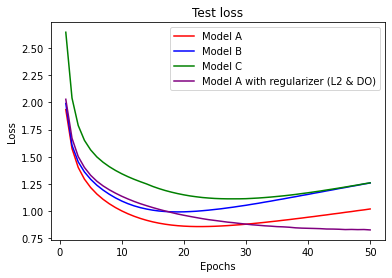

In [ ]:
# Plot validation loss curves
epochs = range(1, len(hista['train_loss']) + 1)

plt.plot(epochs, hista['test_loss'], 'r-', label='Model A')
plt.plot(epochs, histb['test_loss'], 'b-', label='Model B')
plt.plot(epochs, histc['test_loss'], 'g-', label='Model C')
plt.plot(epochs, histf['test_loss'], '-', color='purple', label='Model A with regularizer (L2 & DO)')

plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Test Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

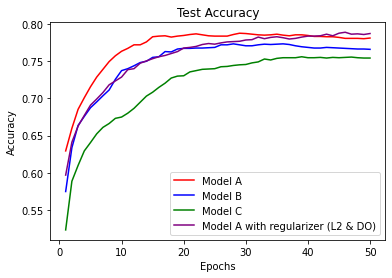

In [ ]:
# Plot validation accuracy curves
epochs = range(1, len(hista['test_acc']) + 1)

plt.plot(epochs, hista['test_acc'], 'r-', label='Model A');
plt.plot(epochs, histb['test_acc'], 'b-', label='Model B');
plt.plot(epochs, histc['test_acc'], 'g-', label='Model C');
plt.plot(epochs, histf['test_acc'], '-', color='purple', label='Model A with regularizer (L2 & DO)');

plt.title('Test Accuracy');
plt.xlabel('Epochs');
plt.ylabel('Accuracy');
plt.legend();

plt.show()

Text(0.5, 1.0, 'Test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

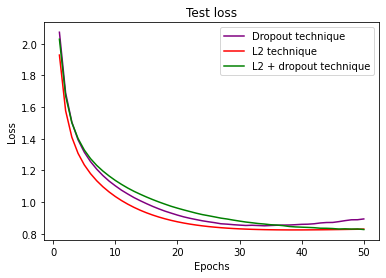

In [ ]:
# Plot validation loss curves
epochs = range(1, len(hista['train_loss']) + 1)


plt.plot(epochs, histd['test_loss'], '-', color='purple', label='Dropout technique')
plt.plot(epochs,histe['test_loss'], '-', color='red', label='L2 technique')
plt.plot(epochs,histf['test_loss'], '-', color='green', label='L2 + dropout technique')

plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Test Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

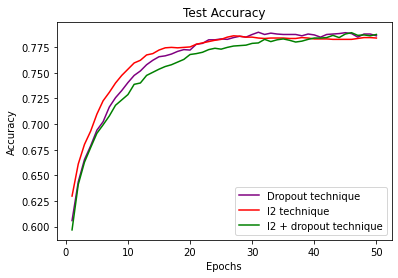

In [ ]:
# Plot validation accuracy curves
epochs = range(1, len(hista['test_acc']) + 1)


plt.plot(epochs, histd['test_acc'], '-', color='purple', label='Dropout technique');
plt.plot(epochs,histe['test_acc'], '-', color='red', label='l2 technique')
plt.plot(epochs,histf['test_acc'], '-', color='green', label='l2 + dropout technique')

plt.title('Test Accuracy');
plt.xlabel('Epochs');
plt.ylabel('Accuracy');
plt.legend();

plt.show()

**Analysis on the following:**


**Are you able to find a good strategy to address overfitting in this case? If so, why do you think the strategy you used can be effective?**

The best strategy to address overfitting in this specific case would be to either to use a L1, L2 regulizer or a combination of the L1, L2 regulizers along with the drop out technique. As you can see in the graphs that I've plotted above for different techniques, you can see that using a stand alone L2 regulizer or a combination of both the L2 and the drop technique works the best for fixing overfitting. Either one of these techniques can be used in order to fix overfitting. 

**Reasons:**

**Dropout Technique**

The reasons to why this strategy is effective is because, while using the dropout technique few of the nodes/units are dropped out while training, this forces the neighbouring nodes in a given hidden layer to perform better. Adittionaly, these dropped out nodes/units are back when testing the model by scaling down the output values by a factor equal to the dropout rate. 

**L1/L2 regularization** 

This works on the principal that a simpler a model is, the better it performs on the test set. That is, increasing the model complexity can lead to overfitting. One of the ways to make the model less complex is to put constrains on the complexity by forcing the weights to take smaller values. Thus is done by L1/L2 regulizers where the the loss function of the network is given a penality or a cost for having large weights. We've specifically targeted on L2 regularization for this example where the cost added is proportional to the square of the value of the weights coefficients. 

Either using L2 alone or combining the above two techniques give you the best chances to reduce overfitting in this specific scenario by reducing it without altering the accuracy. 



**What other strategies have you tried? Are they effective?**

The other strategies that I tried were using dropout techinque by itself and the batch normalization. 

Out of the two, the dropout technique seemed to be more effective compared to batch normalization. But, comparing the dropout technqiue with the L2 Regulizer or combining both L2 & Dropout, it seemed that using a L2 regulizer or combining L2 & Dropout technique worked better and a visual representation if given in the graph above. 

**Overall, through Q1 and Q2, can you summarize what you have learned regarding modeling and training?**



*   Increasing the model complexity leads to overfitting
*   Increasing the number of hidden layers does not result in a better performing model
*   Increasing the number of units in the hidden layer does not result in a better performing model.
*   All the three regularization techniques 'L1 & L2 Regularization', 'Dropout technique', 'Batch Normalization' can prevent overfitting but not all three work the best in every situation, one must implement a regularization technique or a combination of them based on the given problem to avoid overfitting.  
*  Tuning of hyperparameters is very important in order to get a good performing model. 









### Imbalanced Dataset

Here we have a very imbalance dataset. Many classes only have a few training samples. As a result, when you display the classification report (see below), you'll see precision/recall/f1 is very low for some classes. 

Assuming that it is very difficult to collect extra samples, could you think of one method to improve the peformance of some underpresented classes without hurting the overall performance?

Implement your method and demonstrate the improvement you can achieve. 

Please describe your method as markdowns and explain why this method can address dataset skewness.

In [ ]:
# Classification report of Model in Q2

#print(classification_report(Y, P))

**Weighting Samples**

In [ ]:
#Because there’s a class imbalance, we use stratified split to create our train and test sets.
target_list = []
i = 0
for i in train_labels:
    target_list.append(i)                                           
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [ ]:
#Obtaining the count of all classes in our training set.
Count_vals = pd.Series(train_labels).value_counts()

In [ ]:
#We use the reciprocal of each count to obtain it’s weight.
class_count = [i for i in Count_vals]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 

print(class_weights)

tensor([0.0003, 0.0005, 0.0018, 0.0023, 0.0023, 0.0026, 0.0037, 0.0058, 0.0072,
        0.0081, 0.0099, 0.0100, 0.0109, 0.0135, 0.0152, 0.0161, 0.0182, 0.0200,
        0.0204, 0.0204, 0.0208, 0.0208, 0.0222, 0.0244, 0.0256, 0.0256, 0.0278,
        0.0312, 0.0333, 0.0385, 0.0417, 0.0417, 0.0476, 0.0500, 0.0526, 0.0526,
        0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0667, 0.0769, 0.0833, 0.0909,
        0.1000])


In [ ]:
#Weighting each sample
class_weights_all = class_weights[target_list]

In [ ]:
#Initializing WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [ ]:
preds = []

In [ ]:
# Define a train function



def new_train_model(model, train_dataset, test_dataset, device, lr=0.0002, epochs=30, batch_size=256, l2= 0):  
    
    history = {'train_loss': [], 
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    
    # add your code

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=weighted_sampler)    #Adding Sampler
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    
    model = model.to(device)   

  
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay= l2) 

    
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x, y in train_loader:
          
            x = x.to(device)
            y = y.to(device)
            
            outputs = model(x) 
            score, pred = torch.max(outputs, 1)    
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).sum().item() / batch_size
            
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += cur_train_loss
            train_acc += cur_train_acc


        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                
                x = x.to(device)
                y = y.to(device)
                
                outputs = model(x) 
                score, pred = torch.max(outputs,1)                  
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().item() / batch_size             
                
                test_loss += cur_test_loss
                test_acc += cur_test_acc    
               # y_pred_list.append(pred.cpu().detach().numpy()[0])

        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f} train_acc:{train_acc:.5f}, Test loss:{val_loss:.5f} Test acc:{val_acc:.5f}")
        
  
    return history

    

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Train Model 

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

# load model
modelz = linear_model(h1 = 128)
summary(modelz, (24, 10000))
histx = new_train_model(modelz, train_dataset, test_dataset, device, epochs=50, l2 = 0)    

Layer (type:depth-idx)                   Output Shape              Param #
linear_model                             --                        --
├─Sequential: 1-1                        [24, 46]                  --
│    └─Linear: 2-1                       [24, 128]                 1,280,128
│    └─ReLU: 2-2                         [24, 128]                 --
│    └─Linear: 2-3                       [24, 46]                  5,934
Total params: 1,286,062
Trainable params: 1,286,062
Non-trainable params: 0
Total mult-adds (M): 30.87
Input size (MB): 0.96
Forward/backward pass size (MB): 0.03
Params size (MB): 5.14
Estimated Total Size (MB): 6.14

Training Start
Epoch:1 / 50, train loss:2.42863 train_acc:0.60373, Test loss:1.95887 Test acc:0.61285
Epoch:2 / 50, train loss:1.44464 train_acc:0.72179, Test loss:1.58999 Test acc:0.65365
Epoch:3 / 50, train loss:1.15611 train_acc:0.75684, Test loss:1.41776 Test acc:0.67882
Epoch:4 / 50, train loss:0.96362 train_acc:0.79319, Test loss:1.31928 Test acc:0.68707
Epoch:5 / 50, train loss:0.83819 train_acc:0.81554, Test loss:1.24336 Test acc:0.70877
Epoch:6 / 50, train loss:0.71201 train_acc:0.83789, Test loss:1.19241 Test acc:0.71918
Epoch:7 / 50, train loss:0.64278 train_acc:0.85276, Test loss:1.14767 Test acc:0.73351
Epoch:8 / 50, train loss:0.54156 train_acc:0.87956, Test loss:1.11036 Test acc:0.74045
Epoch:9 / 50, train loss:0.50688 train_acc:0.88661, Test loss:1.07988 Test acc:0.74436
Epoch:10 / 50, train loss:0.47664 train_acc:0.88780, Test loss:1.05533 Test acc:0.74696
Epoch:11 / 50, train loss:0.42010 train_acc:0.90191, Test loss:1.03084 Test acc:0.75347
Epoch:12 / 50, train loss:

In [ ]:
test_loader = DataLoader(test_dataset)
model = modelz.to(device)
model.eval()
y_pred_list = []
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device)
        outputs = modelz(x)
        score,pred = torch.max(outputs, 1)
        y_pred_list.append(pred.cpu().detach().numpy()[0])

y_true = y_test
y_pred = np.array(y_pred_list)

linear_model(
  (classifier): Sequential(
    (0): Linear(in_features=10000, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=46, bias=True)
  )
)

In [ ]:
from sklearn.metrics import classification_report
classification_report(y_true, y_pred, output_dict=True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'f1-score': 0.761904761904762,
  'precision': 0.8888888888888888,
  'recall': 0.6666666666666666,
  'support': 12},
 '1': {'f1-score': 0.7359307359307359,
  'precision': 0.6746031746031746,
  'recall': 0.8095238095238095,
  'support': 105},
 '10': {'f1-score': 0.8813559322033899,
  'precision': 0.896551724137931,
  'recall': 0.8666666666666667,
  'support': 30},
 '11': {'f1-score': 0.6594594594594596,
  'precision': 0.5980392156862745,
  'recall': 0.7349397590361446,
  'support': 83},
 '12': {'f1-score': 0.3,
  'precision': 0.42857142857142855,
  'recall': 0.23076923076923078,
  'support': 13},
 '13': {'f1-score': 0.6027397260273972,
  'precision': 0.6111111111111112,
  'recall': 0.5945945945945946,
  'support': 37},
 '14': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 2},
 '15': {'f1-score': 0.1818181818181818,
  'precision': 0.5,
  'recall': 0.1111111111111111,
  'support': 9},
 '16': {'f1-score': 0.7109004739336493,
  'precision': 0.6696428571428571,
  'recall

In [ ]:
report = classification_report(y_true, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
print(df)

              precision    recall  f1-score      support
0              0.888889  0.666667  0.761905    12.000000
1              0.674603  0.809524  0.735931   105.000000
2              0.764706  0.650000  0.702703    20.000000
3              0.907692  0.943419  0.925211   813.000000
4              0.818359  0.883966  0.849899   474.000000
5              0.000000  0.000000  0.000000     5.000000
6              0.800000  0.857143  0.827586    14.000000
7              1.000000  0.333333  0.500000     3.000000
8              0.735294  0.657895  0.694444    38.000000
9              0.863636  0.760000  0.808511    25.000000
10             0.896552  0.866667  0.881356    30.000000
11             0.598039  0.734940  0.659459    83.000000
12             0.428571  0.230769  0.300000    13.000000
13             0.611111  0.594595  0.602740    37.000000
14             0.000000  0.000000  0.000000     2.000000
15             0.500000  0.111111  0.181818     9.000000
16             0.669643  0.7575

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Explanation**

Because there’s a class imbalance, we use stratified split to create our train, validation, and test sets.
While it helps, it still does not ensure that each mini-batch of our model see’s all our classes. We need to over-sample the classes with less number of values. To do that, we use the WeightedRandomSampler.
First, we obtain a list called target_list which contains all our outputs. This list is then converted to a tensor and shuffled.

Then, we obtain the count of all classes in our training set. We use the reciprocal of each count to obtain it’s weight. Now that we’ve calculated the weights for each class, we can proceed.

Finally, let’s initialize our WeightedRandomSampler. We’ll call this in our dataloader below.